In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : QhKElie3 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

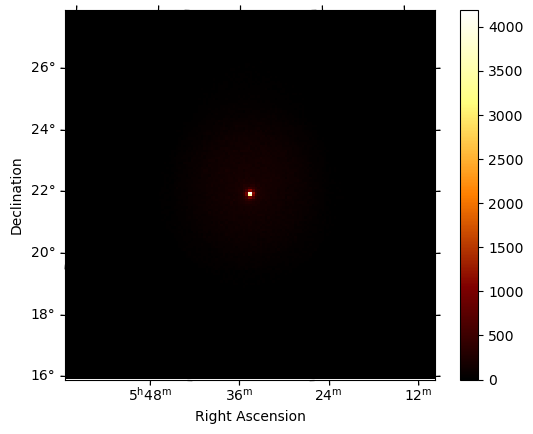

In [3]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = 0.0
sigma = 0.1


sys = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                          bias = bias, 
                         sigma = sigma,
                        rnd = False)
zero = 1e-12
penalising_invcovmatrix = np.zeros((4, 4))
if bias ==0 :
    b_ = zero
else:
    b_ = bias
np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigma**2])

dataset = sys.create_dataset()
dataset_N = sys.create_dataset_N()
dataset_N.models.parameters['bias'].frozen = True

dataset_N.penalising_invcovmatrix = penalising_invcovmatrix



dataset_N.models.parameters['amplitude'].frozen = True
dataset.models.parameters['amplitude'].frozen = True

datasets = Datasets(dataset)
datasets_N = Datasets(dataset_N)



evaluate: 0.1 0.0
evaluate: 0.1 0.0


In [5]:
print(datasets)
print(datasets_N)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : ifS13YA7
  Instrument : 
  Models     : ['Source', 'ifS13YA7-bkg']


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : dataset N
  Instrument : 
  Models     : ['Source', 'dataset N-bkg', 'dataset N-irf']




In [6]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.1, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(datasets)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 108
	total stat : -753579.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 1.29 s, sys: 23.7 ms, total: 1.32 s
Wall time: 1.32 s


In [7]:
fit.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 108              │
│ EDM = 3.93e-07 (Goal: 0.0002)    │            time = 1.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index │   2.30    │   0.04    │            │            │         │         │       │
│ 1 │ par_001_sigma │    1.9    │    1.2    │            │            │    0    │         │       │
│ 2 │ par_002_norm  │  1.0000   │  0.0021   │            │            │         │         │       │
│ 3 │ par_003_tilt  │  -0.000   │   0.002   │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────┐
│               │ par_000_index par_001_sigma  par_002_norm  par_003_tilt │
├───────────────┼─────────────────────────────────────────────────────────┤
│ par_000_index │       0.00195      -0.00292     -9.99e-09     -4.42e-06 │
│ par_001_sigma │      -0.00292          1.39      1.11e-06      8.46e-06 │
│  par_002_norm │     -9.99e-09      1.11e-06      4.24e-06      2.36e-06 │
│  par_003_tilt │     -4.42e-06      8.46e-06      2.36e-06      3.84e-06 │
└───────────────┴─────────────────────────────────────────────────────────┘

In [8]:
%%time
fit_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.1, "strategy": 2}
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run([datasets_N[0]])


evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.42387223510054084 0.0
evaluate: -0.42387223510054084 0.0
evaluate: 0.042387223510054084 0.0
evaluate: -0.042387223510054084 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.042387223510054084 0.0
evaluate: -0.042387223510054084 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0.0
evaluate: 0.0 0

In [9]:
fit_N.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 134              │
│ EDM = 5.47e-07 (Goal: 0.0002)    │           time = 24.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index      │   2.30    │   0.04    │            │            │         │         │       │
│ 1 │ par_001_sigma      │    1.9    │    1.2    │            │            │    0    │         │       │
│ 2 │ par_002_norm       │  1.0000   │  0.0021   │            │            │         │         │       │
│ 3 │ par_003_tilt       │  -0.000   │   0.002   │            │            │         │         │       │
│ 4 │ par_004_resolution │    0.0    │    0.1    │            │            │         │         │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────┐
│                    │      par_000_index      par_001_sigma       par_002_norm       par_003_tilt par_004_resolution │
├────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│      par_000_index │            0.00195           -0.00292          -9.88e-09          -4.42e-06          -1.89e-05 │
│      par_001_sigma │           -0.00292               1.39           1.11e-06           8.46e-06           1.83e-05 │
│       par_002_norm │          -9.88e-09           1.11e-06           4.24e-06           2.36e-06          -6.32e-08 │
│       par_003_tilt │          -4.42e-06           8.46e-06           2.36e-06           3.84e-06          -5.94e-08 │
│ par_004_resolution │          -1.89e-05           1.83e-05          -6.32e-08          -5.94e-08            0.00981 │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

In [15]:
datasets.parameters['index'].error

0.044114853483696946

In [16]:
datasets_N.parameters['index'].error

0.04411528748336972

# Stat Contours

In [10]:
fit.minuit.parameters

('par_000_index', 'par_001_sigma', 'par_002_norm', 'par_003_tilt')

E MnContours unable to find Lower y Value for x Parameter 3


ValueError: zero-size array to reduction operation minimum which has no identity

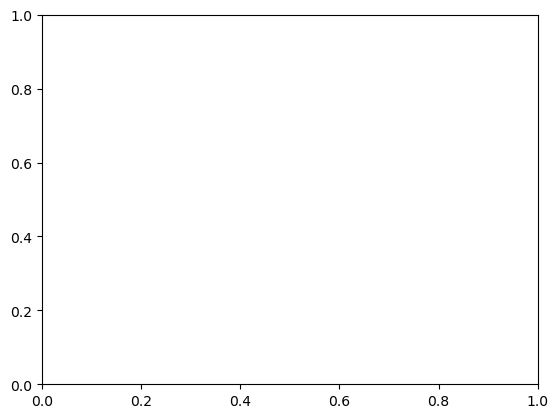

In [29]:
%%time
contour = fit.minuit.draw_mncontour("par_003_tilt", "par_002_norm", cl=0.68, size=20)


In [12]:
p = contour.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
plt.plot(x, y, "o-");


NameError: name 'contour' is not defined

In [ ]:
%%time
contour_N = fit_N.minuit.mncontour("par_004_tilt", "par_003_norm", cl=0.68,size=20)


In [ ]:
contour_N

In [ ]:
p_N = contour_N#.collections[0].get_paths()[0]
#v_N = p_N.vertices
x_N = contour_N[:,0]
y_N = contour_N[:,1]
plt.plot(x_N, y_N, "o-");
#plt.plot(x, y, "o-");



In [ ]:
fit_N.minuit.draw_profile("par_003_norm");

In [19]:
fit_N.minuit.parameters

('par_000_index',
 'par_001_sigma',
 'par_002_norm',
 'par_003_tilt',
 'par_004_resolution')

evaluate: -0.19806566992170457 0.0
evaluate: -0.19406357204210373 0.0
evaluate: -0.19006147416250285 0.0
evaluate: -0.186059376282902 0.0
evaluate: -0.18205727840330113 0.0
evaluate: -0.17805518052370028 0.0
evaluate: -0.1740530826440994 0.0
evaluate: -0.17005098476449856 0.0
evaluate: -0.16604888688489772 0.0
evaluate: -0.16204678900529684 0.0
evaluate: -0.15804469112569597 0.0
evaluate: -0.15404259324609512 0.0
evaluate: -0.15004049536649428 0.0
evaluate: -0.1460383974868934 0.0
evaluate: -0.14203629960729255 0.0
evaluate: -0.1380342017276917 0.0
evaluate: -0.13403210384809083 0.0
evaluate: -0.13003000596848996 0.0
evaluate: -0.1260279080888891 0.0
evaluate: -0.12202581020928825 0.0
evaluate: -0.11802371232968739 0.0
evaluate: -0.11402161445008654 0.0
evaluate: -0.11001951657048568 0.0
evaluate: -0.10601741869088482 0.0
evaluate: -0.10201532081128396 0.0
evaluate: -0.0980132229316831 0.0
evaluate: -0.09401112505208224 0.0
evaluate: -0.09000902717248138 0.0
evaluate: -0.08600692929288

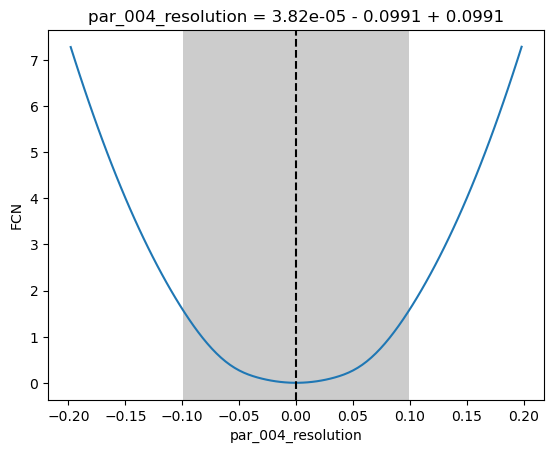

In [20]:

fit_N.minuit.draw_profile("par_004_resolution");


evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e-05 0.0
evaluate: 3.817511853792646e

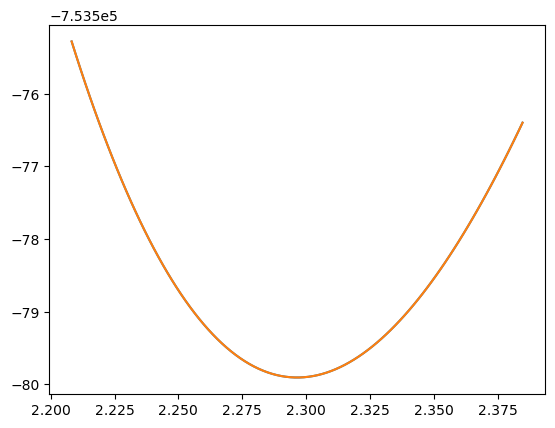

In [17]:
x_N, y_N = fit_N.minuit.profile("par_000_index")
x, y = fit.minuit.profile("par_000_index")

plt.plot(x, y);
plt.plot(x_N, y_N);

In [ ]:
datasets.parameters.to_table()

In [ ]:
datasets_N.parameters.to_table()

evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: -0.001264154351193919 0.0
evaluate: 0.012570303568447388 0.0
evaluate: -0.015098612270835227 0.0
evaluate: 0.04112327395620531 0.0
evaluate: -0.04365158265859315 0.0
evaluate: 0.00024696832729327925 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: -0.00044207469439842893 0.0
evaluate: 0.04103298677735663 0.0
evaluate: -0.04191713616615349 0.0
evaluate: 6.93552473

evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: 0.008264543328516324 0.0
evaluate: -0.008272997658018044 0.0
evaluate: 0.0016495269339025765 0.0
evaluate: -0.0016579812634042973 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: 0.04133962530158505 0.0
evaluate: -4.2271647508612675e-06 0.0
evaluate: 0.04133962530158505 0.0
evaluate: 0.04133962530158505 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: -4.22716475086038e-06 0.0
evaluate: 0.04134232985582477 0.0
evaluate: -0.04135078418532649 0.0
evaluate: 3.3713701006165307e-06 0.0
evaluate: 1.8715644815973297e-05 0.0
evaluate: 6.067163038084848e-06 0

evaluate: -1.6887661923385185e-07 0.0
evaluate: -7.793190534427287e-08 0.0
evaluate: -7.338466964979394e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: -7.315730786506998e-08 0.0
evaluate: 0.04104648556019805 0.0
evaluate: -0.04104663187481378 0.0
evaluate: -0.00012791205395977365 0.0
evaluate: -1.5565928915303284e-05 0.0
evaluate: -8.477958882369808e-07 0.0
evaluate: -1.1188923688366552e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -1.6443291858073423e-07 0.0
evaluate: -8.090639592183852e-07 0.0
evaluate: -5.117010708592703e-07 0.0
evaluate: -3.630196266797129e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -2.143381825001555e-07 0.0
evaluate: -2.143381825001555e-07 0.0
e

evaluate: -2.061905281114452e-05 0.0
evaluate: -2.061905281114452e-05 0.0
evaluate: -2.061905281114452e-05 0.0
evaluate: -2.061905281114452e-05 0.0
evaluate: -2.061905281114452e-05 0.0
evaluate: 0.04393762292277389 0.0
evaluate: -0.043978861028396175 0.0
evaluate: -5.322899149545049e-07 0.0
evaluate: -1.4489159166853284e-05 0.0
evaluate: -1.824893315044451e-05 0.0
evaluate: -1.9623407494126893e-05 0.0
evaluate: -2.0195393724227587e-05 0.0
evaluate: -2.0431757062646115e-05 0.0
evaluate: -2.0538765898545613e-05 0.0
evaluate: -2.058532807201107e-05 0.0
evaluate: -2.0591747946191937e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: -2.0542780244175558e-05 0.0
evaluate: 0.04390141661221498 0.0
evaluate: -0.043942502172703325 0.0
evaluate: 2.998151413393929e-06 0.0
evaluate: -1.3186568964469933e-05 

evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate: 0.231901061362545 0.0
evaluate

evaluate: -0.19806566992170457 0.0
evaluate: -0.19806566992170457 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.23195272690001528 0.0
evaluate: -0.2319527

evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 0.008205793801541383 0.0
evaluate: -0.008200809202586161 0.0
evaluate: 0.001643152599890366 0.0
evaluate: -0.001638168000935143 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 0.041018999809796466 0.0
evaluate: 2.49229947760915e-06 0.0
evaluate: 0.041018999809796466 0.0
evaluate: 0.041018999809796466 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 2.4922994776115607e-06 0.0
evaluate: 0.041

evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.19448583366854158 0.0
evaluate: -0.1944858

evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19048545449313706 0.0
evaluate: 0.19

evaluate: 0.13356069011943228 0.0
evaluate: 0.13356069011943228 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.13919116998628978 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11096601003299249 0.0
evaluate: 0.11

evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.12688050139091933 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13492350269322775 0.0
evaluate: 0.13

evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.17733542634849558 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.12641975281774526 0.0
evaluate: -0.1264197

evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.13393341968147746 0.0
evaluate: -0.18102655855053734 0.0
evaluate: -0.18102655855053734 0.0
evaluate: -0.1810265

evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19457219403861914 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.19585423135965876 0.0
evaluate: -0.1958542

evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 0.1784869754011066 0.0
evaluate: 

evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19246067232635175 0.0
evaluate: 0.19

evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: 0.06986203111101587 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0.0
evaluate: -0.066641627374284 0

evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09210784017051274 0.0
evaluate: 0.09

evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate: 0.148510645769382 0.0
evaluate

evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.04581628074729897 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluate: -0.4896398961453572 0.0
evaluat

evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.21990259569228326 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.22103548096200945 0.0
evaluate: -0.2210354

evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20463854347693974 0.0
evaluate: 0.20

evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17395772505600776 0.0
evaluate: 0.17

evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.22513856796500042 0.0
evaluate: -0.2251385

evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1374119327725311 0.0
evaluate: -0.1

evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04919834054333113 0.0
evaluate: 0.04496234988745603 0.0
evaluate: 0.04496234988745603 0.0
evaluate: 0.04496234988745603 0.0
evaluate: 0.04496234988745603 0.0
evaluate: 0.04

evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.17218838440078832 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21531926180884187 0.0
evaluate: 0.21

evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19744218256087837 0.0
evaluate: 0.19

evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.17849627355327374 0.0
evaluate: 0.21711984378030624 0.0
evaluate: 0.21711984378030624 0.0
evaluate: 0.21711984378030624 0.0
evaluate: 0.21711984378030624 0.0
evaluate: 0.21

evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19205297143786187 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19288331120848282 0.0
evaluate: 0.19

evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 0.0725942095401046 0.0
evaluate: 

evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: -0.06452268855837787 0.0
evaluate: 0.03526810

evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14826325763864584 0.0
evaluate: 0.14

evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.02530481926742488 0.0
evaluate: -0.031014550491417978 0.0
evaluate: -0.031014550491417978 0.0
evaluate: -0.031014550491417978 0.0
evaluate: -0.031014550491417978 0.0
evaluate: -0.031014550491417978 0.0
evaluate: -0.03

evaluate: -0.14281274870885693 0.0
evaluate: -0.14281274870885693 0.0
evaluate: -0.14281274870885693 0.0
evaluate: -0.14281274870885693 0.0
evaluate: -0.14281274870885693 0.0
evaluate: -0.14281274870885693 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.23733499067905114 0.0
evaluate: -0.2373349

evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14224816626710965 0.0
evaluate: 0.14

evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.2219025829472146 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
evaluate: 0.097745793147874 0.0
e

evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12115671341741924 0.0
evaluate: 0.12

evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.12387908718719673 0.0
evaluate: -0.1238790

evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.13854943719830343 0.0
evaluate: -0.1385494

evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.05076625088160436 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04640212139046998 0.0
evaluate: 0.04

evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21323208758800732 0.0
evaluate: 0.21

evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22584057212003322 0.0
evaluate: 0.22

evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.17797246218944424 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.21548075270250336 0.0
evaluate: -0.2154807

evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: -0.19175518866746016 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.1784940081447518 0.0
evaluate: 0.17849400814

evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.19628880625037115 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.0
evaluate: -0.2311282726951962 0.

evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.22991262760514594 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164 0.0
evaluate: -0.2076683016220164

evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.19162382863565378 0.0
evaluate: -0.1916238

evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19035221187267415 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.19102953996033656 0.0
evaluate: -0.1910295

evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.06957205509105947 0.0
evaluate: 0.07487999229422929 0.0
evaluate: 0.07

evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.07232002096090466 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0

evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.048546608372743334 0.0
evaluate: 0.04854660

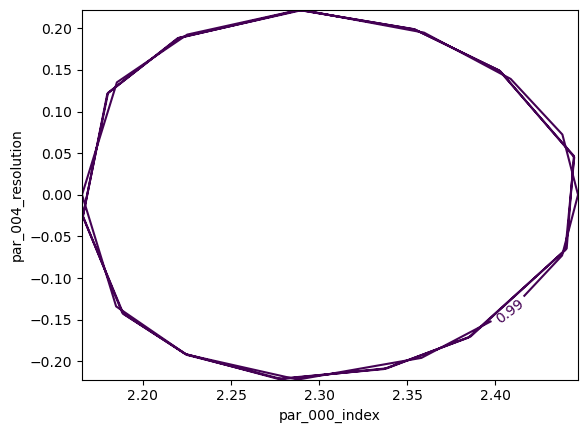

In [24]:
%%time
contour_signal = fit_N.minuit.draw_mncontour("par_000_index", "par_004_resolution", cl=0.99);

In [25]:
contour_signal

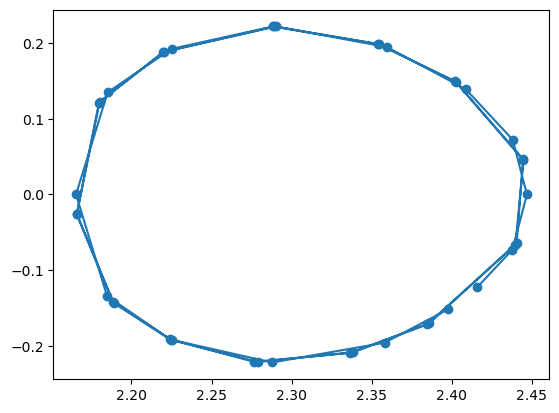

In [26]:
p = contour_signal.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
plt.plot(x, y, "o-");


In [ ]:

# find the minimum again after messing around with the parameters
fit_N.minuit.migrad()

# draw matrix of likelihood contours for all pairs of parameters at 1, 2, 3 sigma
fit_N.minuit.draw_mnmatrix();



evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201682824117302 0.0
evaluate: -0.04194085331775366 0.0
evaluate: -1.9092163005237007e-06 0.0
evaluate: 1.3201059070501004e-05 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 4.429342735928506e-06 0.0
evaluate: 0.04300741620587901 0.0
evaluate: -0.04299855752040715 0.0
evaluate: -7.718119361288448e-07 0.0
evaluate: 2.2468620657936783e-06 0.0
evaluate: 3.4681154593903943e-06 0.0
evaluate: 3.9970973959438854

evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 7.580259608117787e-06 0.0
evaluate: 0.04292183393296165 0.0
evaluate: -0.04290667341374541 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -6.117855153711689e-07 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: -1.775349571969979e-09 0.0
evaluate: 0.0429206357976272 0.0
evaluate: -0.04292063934832634 0.0
evaluate: 1.4007421706450459e-05 0.0
evaluate: 6.986845032291515e-07 0.0
evaluate: 3.32476430680861e-08 0.0
evaluate: 1.159789678361701e-09 0.0
evaluate: -1.1409987172811996e-09 0.0
evaluate: -1.1409987172811996e-09 0.0
evaluate: -1.1409987172811996e-09 0.0
evaluate: -1.1409987172811996e-09 0.0
evaluate: -1.140998

evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: 0.008544893486952752 0.0
evaluate: -0.008545739374214515 0.0
evaluate: 0.0017086403424858446 0.0
evaluate: -0.0017094862297476093 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: -4.229436308823074e-07 0.0
evaluate: 0.04272615920928728 0.0
evaluate: -4.229436308816892e-07 0.0
evaluate: 0.04272615920928728 0.0
evaluate: 0.04272615920928728 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.79874

evaluate: -3.133174336351926e-06 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 1.703394293485438e-05 0.0
evaluate: 0.042489557428303314 0.0
evaluate: -0.042455489542433604 0.0
evaluate: -2.2110616527393947e-07 0.0
evaluate: 1.0244410413659467e-05 0.0
evaluate: 1.3904464015803165e-05 0.0
evaluate: 1.549306514532912e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 1.5863713674208547e-05 0.0
evaluate: 0.04249106064682143 0.0
evaluate: -0.04245933321947301 0.0
evaluate: -0.01917141538376455 0.0
evaluate: -0.0009435002411977293 0.0
evaluate: -3.210448406938835e-05 0.0
evaluate: 1.3465303787028702e-05 0.0
evaluate: 1.574379

evaluate: 0.00847856634781495 0.0
evaluate: -0.008480340023359983 0.0
evaluate: -8.868377725174171e-07 0.0
evaluate: -8.868377725174171e-07 0.0
evaluate: 0.04239637909016482 0.0
evaluate: -8.868377725165799e-07 0.0
evaluate: 0.04239637909016482 0.0
evaluate: 0.04239637909016482 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016939409979186 0.0
evaluate: -0.041940964486559824 0.0
evaluate: -3.429065183789075e-06 0.0
evaluate: 1.8426068878401788e-05 0.0
evaluate: 1.8426068878401788e-05 0.0
evaluate: 1.8426068878401788e-05 0.0
evaluate: 1.8426068878401788e-05 0.0
evaluate: 1.8426068878401788e-05 0.0
evaluate: 1.8426068878401788

evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 0.008472827161677984 0.0
evaluate: -0.008429475554369513 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 2.167580365423628e-05 0.0
evaluate: 0.04227743259377298 0.0
evaluate: 2.1675803654239156e-05 0.0
evaluate: 0.04227743259377298 0.0
evaluate: 0.04227743259377298 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.

evaluate: -8.612227305763885e-05 0.0
evaluate: -2.5943142923217656e-05 0.0
evaluate: 2.5180338949162573e-06 0.0
evaluate: 1.60465392599541e-05 0.0
evaluate: 2.252657362147368e-05 0.0
evaluate: 2.5601158240182487e-05 0.0
evaluate: 2.7122138382743743e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 0.04215444630843447 0.0
evaluate: -0.04209767576315471 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate: 2.8385272639880802e-05 0.0
evaluate

evaluate: -0.0017070498038875585 0.0
evaluate: -0.0007056915737988856 0.0
evaluate: -0.00030877306354680945 0.0
evaluate: -0.00013044092854221166 0.0
evaluate: -4.57731243317597e-05 0.0
evaluate: -4.527119839557236e-06 0.0
evaluate: 1.5805976227507302e-05 0.0
evaluate: 2.5926439244492035e-05 0.0
evaluate: 3.095317084188859e-05 0.0
evaluate: 3.3458291134428194e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 0.042042814208140405 0.0
evaluate: -0.041970928062578586 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.594307278091155e-05 0.0
evaluate: 3.5943072

evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201695007059478 0.0
evaluate: -0.041940975147175416 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.008433779983486702 0.0
evaluate: -0.008357805060067338 0.0
evaluate: 0.0017171459660650858 0.0
evaluate: -0.0016411710426457223 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201695007059478 0.0
evaluate: 3.798746170968065e-05 0.0
evaluate: 0.04201695007059478 0.0
evaluate: 0.04201695007059478 0.0
evaluate: 3.798746170968169e-05 0.0


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.323744951224812
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201694113264416 0.0
evaluate: -0.0419409662092248 0.0
evaluate: -4.633324867659949e-06 0.0
evaluate: 2.206695344278451e-05 0.0
evaluate: 3.0430138380741312e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 3.248778741199317e-05 0.0
evaluate: 0.041691209875251524 0.0
evaluate: -0.041626234300427535 0.0
evaluate: 2.522364857986272e-06 0.0
evaluate: 2.1503023353171346e-05 0.0
evaluate: 2.7425148865303022e-

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3298127603763104
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201693529369475 0.0
evaluate: -0.041940960370275386 0.0
evaluate: -4.717442907164214e-06 0.0
evaluate: 1.9239614094313307e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 2.291123805499638e-05 0.0
evaluate: 0.04162699868961235 0.0
evaluate: -0.04158117621350235 0.0
evaluate: 1.445118103912142e-06 0.0
evaluate: 1.5224475551548502e-05 0.0
evaluate: 1.9405090501620583e-05 0.0
evaluate: 2.1166816445021975e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.335880569527809
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201692857712033 0.0
evaluate: -0.04194095365370097 0.0
evaluate: -4.789948149675178e-06 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 1.5076201150269932e-05 0.0
evaluate: 0.04156554960132556 0.0
evaluate: -0.04153539719902501 0.0
evaluate: 1.257040595701539e-06 0.0
evaluate: 9.801814742018507e-06 0.0
evaluate: 1.2465834238825739e-05 0.0
evaluate: 1.2465834238825739e-05 0.0
evaluate: 1.246583423882

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3419483786793074
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201692100900163 0.0
evaluate: -0.04194094608558227 0.0
evaluate: -4.857149372973447e-06 0.0
evaluate: 9.660929546479434e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 5.998444162375281e-06 0.0
evaluate: 0.04150386049306656 0.0
evaluate: -0.041491863604741816 0.0
evaluate: 1.1106638165780833e-06 0.0
evaluate: 4.104299209471088e-06 0.0
evaluate: 4.962936260764582e-06 0.0
evaluate: 4.962936260764582e-06

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.348016187830806
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201691261488135 0.0
evaluate: -0.04194093769146199 0.0
evaluate: -4.921060961445611e-06 0.0
evaluate: 3.3893769363947397e-06 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 0.04144644350980791 0.0
evaluate: -0.04144602645886588 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 0.0
evaluate: 2.085254710144948e-07 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3540839969823044
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016903419773904 0.0
evaluate: -0.04194092849635454 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: 0.04139060077937386 0.0
evaluate: -0.0414005595625275 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576820889e-06 0.0
evaluate: -4.979391576

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.360151806133803
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201689344817428 0.0
evaluate: -0.04194091852475492 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -9.073253604601396e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: 0.041340840384642134 0.0
evaluate: -0.04135090286593559 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate: -5.0312406467252165e-06 0.0
evaluate

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.366219615285302
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201688272406608 0.0
evaluate: -0.04194090780064672 0.0
evaluate: -5.081915363564563e-06 0.0
evaluate: -1.4087399101416902e-05 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: 0.04128825869490051 0.0
evaluate: -0.04130593055716298 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.835931131235822e-06 0.0
evaluate: -8.8359311

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3722874244368004
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016871270932496 0.0
evaluate: -0.041940896347513135 0.0
evaluate: -5.130469208283487e-06 0.0
evaluate: -1.787462790358374e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: -1.0165590242422418e-05 0.0
evaluate: 0.04123906544985657 0.0
evaluate: -0.041259396630341415 0.0
evaluate: 1.0068700688264262e-06 0.0
evaluate: -7.778332714761464e-06 0.0
evaluate: -9.55598905823859e-06 0.0
evaluate: -1.

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.378355233588299
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201685911176363 0.0
evaluate: -0.04194088418834427 0.0
evaluate: -5.167021938962501e-06 0.0
evaluate: -2.045935656220074e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: -1.1025981708820949e-05 0.0
evaluate: 0.04119123179277166 0.0
evaluate: -0.04121328375618931 0.0
evaluate: 9.973657669379531e-07 0.0
evaluate: -8.314631227527505e-06 0.0
evaluate: -1.0292723311560209e-05 0.0
evaluate: -1.082535489340175e-05 0.0
evaluate: -1.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3844230427397974
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201659990645717 0.0
evaluate: -0.04194062498303781 0.0
evaluate: 1.112898203962649e-07 0.0
evaluate: 9.416100823380287e-06 0.0
evaluate: -1.9403917067095904e-05 0.0
evaluate: -0.00020878477651352308 0.0
evaluate: -0.0007023292529599325 0.0
evaluate: -0.00045555701473672783 0.0
evaluate: -0.00033217089562512545 0.0
evaluate: -0.00027047783606932427 0.0
evaluate: -0.00023963130629142367 0.0
evaluate: -0.00022420804140247335 0.0
evaluate: -0.00012310536850135268 0.0
evaluate: -0.00012310536850135268 0.0
evaluate: -0.00012310536850135268 0.0
evaluate: -0.00012310536850135268 0.0
evaluate: -0.00012310536850135268 0.0
evalua

evaluate: -5.4720405693726305e-05 0.0
evaluate: -4.8424828677425595e-06 0.0
evaluate: 6.68275479209711e-06 0.0
evaluate: 8.139630637847296e-06 0.0
evaluate: 8.212474430134805e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.214668443296336e-06 0.0
evaluate: 8.215543465042017e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 8.21611661974918e-06 0.0
evaluate: 0.044209963466375214 0.0
evaluate: -0.04419353123313572 0.0
evaluate: 0.0014042299932417017 0.0
evaluate: 0.00023624286080095006 0.0
evaluate: 5.9303625420955494e-05 0.0
evaluate: 1.9637140740501347e-05 0.0
evaluate: 9.939525916190245e-06 0.0
evaluate: 8.378181456096883e-06 0.0
evaluate: 8.224219861566566e-06 0.0
evaluate: 8.21652178184005e-06 0.0
evaluate: 8.216136877853724e-06 0.0
evaluate: 8.216117632654408e-06 0.0
evaluate: 8.216117582009146e-06 0.0
evaluate: 8.21611661974918e-06 0

evaluate: -0.00014700152583210018 0.0
evaluate: 0.04354726607732925 0.0
evaluate: -0.04384126912899345 0.0
evaluate: -0.0001706954526594261 0.0
evaluate: -0.00026547115996872976 0.0
evaluate: -0.0001686864102355823 0.0
evaluate: -0.00017699112755396748 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: -0.00017521538816781093 0.0
evaluate: 0.043546909558918434 0.0
evaluate: -0.043897340335254054 0.0
evaluate: -0.00016326606667235703 0.0
evaluate: -0.0001551437147293188 0.0
evaluate: -0.0001388103422444692 0.0
evaluate: -0.00013665143431204738 0.0
evaluate: -0.00013665143431204738 0.0
evaluate: -0.00013665143431204738 0.0
evaluate: -0.00013665143431204738 0.0
evaluate: -0.00013665143431204738 0.0
evaluate: -0.000136651434312

evaluate: -4.907880309074187e-06 0.0
evaluate: -4.907880309074187e-06 0.0
evaluate: 0.043454784705340976 0.0
evaluate: -0.043464600465959125 0.0
evaluate: -4.72546498288812e-07 0.0
evaluate: 1.726878874485269e-05 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 1.4739955704503662e-06 0.0
evaluate: 0.043462787615266237 0.0
evaluate: -0.04345983962412534 0.0
evaluate: -1.1299665936344603e-07 0.0
evaluate: 1.1701167487792057e-06 0.0
evaluate: 1.4028687474080835e-06 0.0
evaluate: 1.4508695108511585e-06 0.0
evaluate: 1.442553426338918e-06 0.0
evaluate: 1.4467114685950383e-06 0.0
evaluate: 1.459689555897544e-06 0.0
evaluate: 1.4552795333743511e-06 0.0
evaluate: 1.4508695108511585e-06 0.0
evaluate: 1.4508695108511585e-06 0.0
evaluate: 1.4508695108511585e-06 0.0
evaluate: 1.4508695108511585e-06 0.0
evaluate: 1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: 0.04336946403173431 0.0
evaluate: -0.04340076894480662 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: -1.5652456536153088e-05 0.0
evaluate: 0.00866137084111794 0.0
evaluate: -0.008692675754190245 0.0
evaluate: 0.0017197522029946655 0.0
evaluate: -0.0017510571160669719 0.0
evaluate: -1.5652456536153088e-05 0.0


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.194500616297892
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201681463172504 0.0
evaluate: -0.04194083970830568 0.0
evaluate: -1.7652896948790008e-06 0.0
evaluate: 1.288680417320641e-05 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 3.336588254510082e-06 0.0
evaluate: 0.04306347184081004 0.0
evaluate: -0.043056798664301024 0.0
evaluate: -1.108108114536122e-06 0.0
evaluate: 1.3557965058638412e-06 0.0
evaluate: 2.43699955289433e-06 0.0
evaluate: 2.918134148849285e-0

evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201689295897308 0.0
evaluate: -0.04194091803555372 0.0
evaluate: -2.678926879266715e-06 0.0
evaluate: 1.527225318036583e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 1.091413162568688e-05 0.0
evaluate: 0.04269446039370822 0.0
evaluate: -0.04267263213045684 0.0
evaluate: -1.0034649404644791e-07 0.0
evaluate: 6.734429556296933e-06 0.0
evaluate: 9.102690848829773e-06 0.0
evaluate: 1.008440258139249e-05 0.0
evaluate: 1.052502801772069e-05 0.0
evaluate: 1.0729669913981093e-05 0.0
evaluate: 1.0826694094078816e-05 0.0
evaluate: 1.0872244480132064e-05 0.0
evaluate: 1.0894302022537528e-05 0.0
evaluate: 1.090538115055254

evaluate: 0.042467246289267326 0.0
evaluate: -0.04243438251031124 0.0
evaluate: -0.004517990818848893 0.0
evaluate: -0.001367577232418392 0.0
evaluate: -0.0005062975331963476 0.0
evaluate: -0.00019497953168004422 0.0
evaluate: -7.116000345569122e-05 0.0
evaluate: -2.006748874174688e-05 0.0
evaluate: 1.1373131725091143e-06 0.0
evaluate: 9.88755623944091e-06 0.0
evaluate: 1.3774728476805482e-05 0.0
evaluate: 1.5449893842197728e-05 0.0
evaluate: 1.6195747183312753e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 0.042467246289267326 0.0
evaluate: -0.04243438251031124 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.6431889478041263e-05 0.0
evaluate: 1.

evaluate: 0.04224452136573215 0.0
evaluate: -0.04219880394149906 0.0
evaluate: -0.024195082377936127 0.0
evaluate: -0.001682155059394757 0.0
evaluate: -0.0005654709722820071 0.0
evaluate: -0.0002281065156912381 0.0
evaluate: -9.216115087136294e-05 0.0
evaluate: -3.1811536841094864e-05 0.0
evaluate: -2.9507896976047705e-06 0.0
evaluate: 1.0730124684839428e-05 0.0
evaluate: 1.7075151010130566e-05 0.0
evaluate: 2.014236863272457e-05 0.0
evaluate: 2.2126842455995936e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 0.04224452136573215 0.0
evaluate: -0.04219880394149906 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.2858712116544044e-05 0.0
evaluate: 2.

evaluate: 0.0420591860097342 0.0
evaluate: -0.041989514025675426 0.0
evaluate: -0.004452306460129442 0.0
evaluate: -0.00018952113057855573 0.0
evaluate: 2.3618135898988592e-05 0.0
evaluate: 3.427509922286581e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 3.4807947389059666e-05 0.0
evaluate: 0.04205894305236907 0.0
evaluate: -0.04198932715759095 0.0
evaluate: -0.004449412527615079 0.0
evaluate: -0.0015122136878657187 0.0
evaluate: -0.0006296761845956816 0.0
evaluate: -0.0002746740560799696 0.0
evaluate: -0.0001144479528964151 0.0
evaluate: -3.835669018674956e-05 0.0
evaluate: -1.3518290074272682e-06 0.0
evaluate: 1.6869713036520528e-05 0.0
evaluate: 2.5886577198491452e-05 0.0
evaluate: 3.0371104039890243e-05 0.0
evaluate: 3.259749392283243e-05 0.0
evaluate: 3.259749392283243e-05 0.0
evaluate: 3.25

evaluate: 3.798746170968169e-05 0.0
evaluate: 0.00843377960679146 0.0
evaluate: -0.008357804683372095 0.0
evaluate: 0.0017171458907260372 0.0
evaluate: -0.0016411709673066737 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201694818711857 0.0
evaluate: 3.798746170968065e-05 0.0
evaluate: 0.04201694818711857 0.0
evaluate: 0.04201694818711857 0.0
evaluate: 3.798746170968169e-05 0.0


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3207110466490626
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016940588997 0.0
evaluate: -0.04194096566557764 0.0
evaluate: -4.64181589934346e-06 0.0
evaluate: 2.1839372133948425e-05 0.0
evaluate: 3.0195589227487614e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 3.157792823947476e-05 0.0
evaluate: 0.041684789527986876 0.0
evaluate: -0.041621633671507924 0.0
evaluate: 2.2701967026682632e-06 0.0
evaluate: 2.0828208893101348e-05 0.0
evaluate: 2.6611846631205656e-05 0.0
evaluate: 2.8917895370932088e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.33041954129146
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201693068268081 0.0
evaluate: -0.04194095575926145 0.0
evaluate: -4.767985410799268e-06 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 1.6463694617156218e-05 0.0
evaluate: 0.04158291570989083 0.0
evaluate: -0.04154998832065652 0.0
evaluate: 1.2405578345858645e-06 0.0
evaluate: 1.0904576400812697e-05 0.0
evaluate: 1.3851769001170723e-05 0.0
evaluate: 1.470244653019271e-05 0.0
evaluate: 1.470244653019271e-05 0.0
evaluate: 1.47024465301

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.340128035933858
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201691857634728 0.0
evaluate: -0.04194094365292792 0.0
evaluate: -4.875916273612224e-06 0.0
evaluate: 7.848522900616897e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 4.085618144219539e-06 0.0
evaluate: 0.041486357128833654 0.0
evaluate: -0.04147818589254522 0.0
evaluate: 1.106495233757579e-06 0.0
evaluate: 2.901203843060675e-06 0.0
evaluate: 3.381134760438119e-06 0.0
evaluate: 3.381134760438119e-06 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3498365305762556
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201690437462697 0.0
evaluate: -0.04194092945120761 0.0
evaluate: -4.9744765994451005e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: 0.041398147066579204 0.0
evaluate: -0.041403058099228666 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516324733195e-06 0.0
evaluate: -2.455516

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.359545025218653
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016888178704144 0.0
evaluate: -0.04194091325528478 0.0
evaluate: -5.053429472147035e-06 0.0
evaluate: -1.1721951251340229e-05 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: 0.0413134047508908 0.0
evaluate: -0.04132932443800847 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.959843558836806e-06 0.0
evaluate: -7.95984355

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.369253519861051
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016870086412125 0.0
evaluate: -0.041940895162992764 0.0
evaluate: -5.1348662956604595e-06 0.0
evaluate: -1.817862271276424e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: -1.0279564658484427e-05 0.0
evaluate: 0.04123421381112758 0.0
evaluate: -0.041254772940444544 0.0
evaluate: 1.0229035351270064e-06 0.0
evaluate: -7.844293458069546e-06 0.0
evaluate: -9.642118458546112e-06 0.0
evaluate: -1.0104509761309987e-05 0.0
evaluate:

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3789620145034487
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016850192325456 0.0
evaluate: -0.041940875268906094 0.0
evaluate: -5.202824571875537e-06 0.0
evaluate: -2.1697789028997337e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: -1.1440202425144137e-05 0.0
evaluate: 0.04115845781771505 0.0
evaluate: -0.041181338222565346 0.0
evaluate: 9.501728713164348e-07 0.0
evaluate: -8.572178099417235e-06 0.0
evaluate: -1.064240045371383e-05 0.0
evaluate: -1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3886705091458467
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201682858785047 0.0
evaluate: -0.04194085366443111 0.0
evaluate: -5.268176735942631e-06 0.0
evaluate: -2.3116366446679872e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: -1.1971517244297074e-05 0.0
evaluate: 0.04108552537049973 0.0
evaluate: -0.041109468404988324 0.0
evaluate: 9.511832655787311e-07 0.0
evaluate: -8.821487501531226e-06 0.0
evaluate: -1.1038545257353167e-05 0.0
evaluate: -1.

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.398379003788244
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201680536131135 0.0
evaluate: -0.04194083043789199 0.0
evaluate: -5.3208673624538565e-06 0.0
evaluate: -2.327093978615375e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: -1.1938835071469209e-05 0.0
evaluate: 0.04101530691466926 0.0
evaluate: -0.04103918458481219 0.0
evaluate: 9.573266514536695e-07 0.0
evaluate: -8.691426286954976e-06 0.0
evaluate: -1.0764322262559983e-05 0.0
evaluate: -1.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.408087498430642
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.0420167805980343 0.0
evaluate: -0.04194080567461494 0.0
evaluate: -5.342712201361827e-06 0.0
evaluate: -2.2322110722205304e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: -1.2185088050352253e-05 0.0
evaluate: 0.040946890661009365 0.0
evaluate: -0.040971260837110064 0.0
evaluate: 9.064715418439198e-07 0.0
evaluate: -8.767351512984452e-06 0.0
evaluate: -1.1152548699806295e-05 0.0
evaluate: -1.

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4177959930730397
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016754380428935 0.0
evaluate: -0.041940779457009573 0.0
evaluate: -5.37569212458816e-06 0.0
evaluate: -2.1590884676650643e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: -1.20700156544906e-05 0.0
evaluate: 0.040880843518409184 0.0
evaluate: -0.04090498354971816 0.0
evaluate: 9.103538220730737e-07 0.0
evaluate: -8.781678214892925e-06 0.0
evaluate: -1.106349192969218e-05 0.0
evaluate: -1.174802285880142e-05 0.0
evaluate: -1.1964027359434

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4275044877154377
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201672678806718 0.0
evaluate: -0.04194075186464782 0.0
evaluate: -5.394016414689184e-06 0.0
evaluate: -2.071923663999419e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: -1.1906592179242604e-05 0.0
evaluate: 0.04081678938532359 0.0
evaluate: -0.040840602569682076 0.0
evaluate: 8.664115684828853e-07 0.0
evaluate: -8.641895268715615e-06 0.0
evaluate: -1.090009874337491e-05 0.0
evaluate: -1.15

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4372129823578352
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042015912177414017 0.0
evaluate: -0.041939937253994655 0.0
evaluate: 4.810066899866448e-06 0.0
evaluate: -1.3874521166775503e-06 0.0
evaluate: -0.00016727442616575375 0.0
evaluate: -0.0005777982019166247 0.0
evaluate: -0.00037253631404118924 0.0
evaluate: -0.00026990537010347155 0.0
evaluate: -0.00021858989813461268 0.0
evaluate: -0.0001929321621501832 0.0
evaluate: -9.830401820563562e-05 0.0
evaluate: -0.00012412077439720237 0.0
evaluate: -0.00012412077439720237 0.0
evaluate: -0.00012412077439720237 0.0
evaluate: 

evaluate: 0.04833639443543503 0.0
evaluate: -0.04849000723298708 0.0
evaluate: -7.337279261993734e-05 0.0
evaluate: -7.53357259892513e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: 0.04925150989429782 0.0
evaluate: -0.04940281210441271 0.0
evaluate: -8.349303059622818e-05 0.0
evaluate: -7.818957384372646e-05 0.0
evaluate: -7.66940135198099e-05 0.0
evaluate: -7.607502794368117e-05 0.0
evaluate: -7.584786832007472e-05 0.0
evaluate: -7.569215409160518e-05 0.0
evaluate: -7.56592496397447e-05 0.0
evaluate: -7.565151228655878e-05 0.0
evaluate: -7.565112541889948e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.565110505744373e-05 0.0
evaluate: -7.5

evaluate: -2.8295750085589174e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: 0.04583357655359801 0.0
evaluate: -0.04589338101556296 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: 0.04583357655359801 0.0
evaluate: -0.04589338101556296 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471173e-05 0.0
evaluate: -2.9902230982471

evaluate: -8.012581457525987e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: -2.9225728786701064e-05 0.0
evaluate: 0.04429185999092793 0.0
evaluate: -0.04435031144850133 0.0
evaluate: -8.239394487191702e-06 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: -1.7081891199718638e-05 0.0
evaluate: 0.04435405839326194 0.0
evaluate: -0.04438822217566138 0.0
evaluate: -5.5741406870141976e-06 0.0
evaluate: -1.2839818783302413e-05 0.0
evaluate: -1.5063308677389035e-05 0.0
evaluate: -1.5564948011694044e-05 0.0
evaluate: -1.556494801169404

evaluate: 0.043943755347298136 0.0
evaluate: -2.1438849087673795e-06 0.0
evaluate: 0.043943755347298136 0.0
evaluate: 0.043943755347298136 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016721418657144 0.0
evaluate: -0.04194074649523778 0.0
evaluate: -8.992204231811379e-07 0.0
evaluate: 1.1158535366208709e-05 0.0
evaluate: -4.243887963663102e-06 0.0
evaluate: -1.9107196425767103e-05 0.0
evaluate: -0.00021354060709008124 0.0
evaluate: -0.0007165967446896071 0.0
evaluate: -0.00046506867588984416 0.0
evaluate: -0.00033930464148996273 0.0
evaluate: -0.000276422624290022 0.0
evaluate: -0.00024498161569005164 0.0
evaluate: -0.0002

evaluate: 5.571392267749966e-07 0.0
evaluate: 0.04356448231965389 0.0
evaluate: -0.04356336804120034 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 0.008713342175312198 0.0
evaluate: -0.00871222789685865 0.0
evaluate: 0.00174311414644386 0.0
evaluate: -0.0017419998679903098 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 5.571392267749966e-07 0.0
evaluate: 0.04356448231965389 0.0
evaluate: 5.571392267741948e-07 0.0
evaluate: 0.04356448231965389 0.0
evaluate: 0.04356448231965389 0.0
evaluate: 3.798746170968169e-05 0.0
eval

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: 0.043350893839431914 0.0
evaluate: -0.043380395432681365 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: 0.008658378130586604 0.0
evaluate: -0.008687879723836054 0.0
evaluate: 0.0017198749888175404 0.0
evaluate: -0.0017493765820669916 0.0
evaluate: -1.4750796624725535e-05 0.0
evaluate: -1.47

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.195471465762132
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201683603700535 0.0
evaluate: -0.04194086111358599 0.0
evaluate: -1.9975571274753127e-06 0.0
evaluate: 1.3404998493453791e-05 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 5.1611682946143015e-06 0.0
evaluate: 0.042974223818146265 0.0
evaluate: -0.04296390148155704 0.0
evaluate: -6.23112853708587e-07 0.0
evaluate: 2.792717550462949e-06 0.0
evaluate: 4.136880113735787e-06 0.0
evaluate: 4.70316366802

evaluate: -1.0781387107084676e-06 0.0
evaluate: 0.04259227160889057 0.0
evaluate: -0.04259442788631199 0.0
evaluate: 3.431195678560771e-05 0.0
evaluate: 6.913660641073413e-07 0.0
evaluate: -9.89663471967677e-07 0.0
evaluate: -1.0733332276886063e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: -1.0766493587593198e-06 0.0
evaluate: 0.04259063944941583 0.0
evaluate: -0.042592792748133344 0.0
evaluate: 3.4710543134747604e-05 0.0
evaluate: 1.1998181543780496e-05 0.0
evaluate: 4.194858371621396e-06 0.0
evaluate: 1.1356877718666432e-06 0.0
evaluate: -1.3084146002035074e-07 0.0
evaluate: -6.688104509308913e-07 0.0
evaluate: -9.003516777775723e-07 0.0
evaluate: -9.992600910353862e-07 0.0
evaluate: -1.0426333677741237e-06 0.0
evaluate: -1.0604441293974022e-06 0.0
evaluate: -1.0693104486011385e-06 0.0
e

evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 0.04223544019107323 0.0
evaluate: -0.04218796896692565 0.0
evaluate: -0.005334784850467633 0.0
evaluate: -0.0015512108193560471 0.0
evaluate: -0.0006070324904185904 0.0
evaluate: -0.00025032107052266796 0.0
evaluate: -9.927444039534023e-05 0.0
evaluate: -3.2221666865273304e-05 0.0
evaluate: -1.884992758155821e-06 0.0
evaluate: 1.2052606884189677e-05 0.0
evaluate: 1.8312364395240277e-05 0.0
evaluate: 2.118933307873289e-05 0.0
evaluate: 2.2616819467128068e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 0.04223544019107323 0.0
evaluate: -0.04218796896692565 0.0
evaluate: 2.3735612073794466e-05 0.0
evaluate: 2

evaluate: 0.04201694881570672 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201693591751798 0.0
evaluate: -0.041940960994098615 0.0
evaluate: -4.707134029157985e-06 0.0
evaluate: 1.9580585711864103e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 2.3883480244682314e-05 0.0
evaluate: 0.04163338617769659 0.0
evaluate: -0.04158561921720723 0.0
evaluate: 1.5180765944488363e-06 0.0
evaluate: 1.5889303431944464e-05 0.0
evaluate: 2.024937555891

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.335273788612659
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201691724877155 0.0
evaluate: -0.04194094232535219 0.0
evaluate: -4.88671402679298e-06 0.0
evaluate: 6.85179083728351e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 3.0988817182371557e-06 0.0
evaluate: 0.04147709132428771 0.0
evaluate: -0.04147089356085123 0.0
evaluate: 1.0890956249776392e-06 0.0
evaluate: 2.29066473501377e-06 0.0
evaluate: 2.5869698560298608e-06 0.0
evaluate: 2.586969856029860

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3508073800404956
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016893240987535 0.0
evaluate: -0.041940918317568174 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -9.195055843828404e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: 0.04133985655703441 0.0
evaluate: -0.041349919140115265 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291540423577e-06 0.0
evaluate: -5.031291

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3663409714683317
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016864303155044 0.0
evaluate: -0.04194088937973568 0.0
evaluate: -5.148486455480192e-06 0.0
evaluate: -1.9502066313594817e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: -1.0701953162535057e-05 0.0
evaluate: 0.04121117951642276 0.0
evaluate: -0.04123258342274783 0.0
evaluate: 1.0031891948592831e-06 0.0
evaluate: -8.109325777663907e-06 0.0
evaluate: -1.0012489159983567e-05 0.0
evaluate: -1.0509381045612409e-05 0.0
evaluate: 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.381874562896168
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201683082272454 0.0
evaluate: -0.04194085589930518 0.0
evaluate: -5.263082975362055e-06 0.0
evaluate: -2.304470729268413e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: -1.193762799334065e-05 0.0
evaluate: 0.041092701431407815 0.0
evaluate: -0.0411165766873945 0.0
evaluate: 9.676390330386784e-07 0.0
evaluate: -8.800178605272008e-06 0.0
evaluate: -1.101689372596451e-05 0.0
evaluate: -1.1652191273577255e-05 0.0
evaluate: -1.18517305

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3974081543240047
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016793166547085 0.0
evaluate: -0.041940818243127724 0.0
evaluate: -5.328019074218368e-06 0.0
evaluate: -2.30517411782575e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: -1.1952715736966551e-05 0.0
evaluate: 0.0409809589016992 0.0
evaluate: -0.04100486433317313 0.0
evaluate: 9.398761505147887e-07 0.0
evaluate: -8.691447507258824e-06 0.0
evaluate: -1.1005396152558839e-05 0.0
evaluate: -1.166234295211866e-05 0.0
evaluate: -1.1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4129417457518407
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201675168176789 0.0
evaluate: -0.04194077675834853 0.0
evaluate: -5.377891149723201e-06 0.0
evaluate: -2.150528477832697e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: -1.205789296050883e-05 0.0
evaluate: 0.04087434689241424 0.0
evaluate: -0.04089846267833525 0.0
evaluate: 9.196180869423464e-07 0.0
evaluate: -8.766174117652835e-06 0.0
evaluate: -1.1050715565210591e-05 0.0
evaluate: -1.173452725

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4284753371796772
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201670669667495 0.0
evaluate: -0.041940731773255586 0.0
evaluate: -5.397023951449754e-06 0.0
evaluate: -2.0095169536887712e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: -1.1768474443242458e-05 0.0
evaluate: 0.040773095567453094 0.0
evaluate: -0.04079663251633958 0.0
evaluate: 8.656488910453605e-07 0.0
evaluate: -8.522033067384755e-06 0.0
evaluate: -1.0762885091495788e-05 0.0
evaluate: -1.1440801110046195e-05 0.0
evaluate: 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4440089286075137
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016658521505455 0.0
evaluate: -0.041940683598086094 0.0
evaluate: -5.39790004893179e-06 0.0
evaluate: -1.874547042862244e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: -1.1447859129534903e-05 0.0
evaluate: 0.04067660736836254 0.0
evaluate: -0.04069950308662161 0.0
evaluate: 9.207870888829424e-07 0.0
evaluate: -8.227395258894882e-06 0.0
evaluate: -1.0435047000748326e-05 0.0
evaluate: -1.1112411321110227e-05 0.0
evaluate: -1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.45954252003535
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016607449214746 0.0
evaluate: -0.041940632525795385 0.0
evaluate: -5.405408611083601e-06 0.0
evaluate: -1.7580126787825123e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: -1.1176963455415643e-05 0.0
evaluate: 0.04058461445993022 0.0
evaluate: -0.040606968386841046 0.0
evaluate: 8.988331009057332e-07 0.0
evaluate: -8.005805384922631e-06 0.0
evaluate: -1.0169917257393813e-05 0.0
evaluate: -1.084054530783563e-05 0.0
evaluate: 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4750761114631863
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201655375620834 0.0
evaluate: -0.041940578832788976 0.0
evaluate: -5.314099433929037e-06 0.0
evaluate: -1.64765250875935e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: -1.0840818366329697e-05 0.0
evaluate: 0.04049698413680818 0.0
evaluate: -0.040518665773540845 0.0
evaluate: 8.84698063794586e-07 0.0
evaluate: -7.737020922272402e-06 0.0
evaluate: -9.845678789492464e-06 0.0
evaluate: -1.0503773280520699e-05 0.0
evaluate: -1.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.490609702891023
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016497703044144 0.0
evaluate: -0.04194052277962478 0.0
evaluate: -5.254880499096737e-06 0.0
evaluate: -1.559052412967259e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: -1.0506465166391927e-05 0.0
evaluate: 0.04041336563182909 0.0
evaluate: -0.04043437856216187 0.0
evaluate: 8.961547750288457e-07 0.0
evaluate: -7.497727572055222e-06 0.0
evaluate: -9.544879783162812e-06 0.0
evaluate: -1.01

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.506143294318859
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201643953510133 0.0
evaluate: -0.041940464611681966 0.0
evaluate: -5.192561314377547e-06 0.0
evaluate: -1.4847653133783916e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: -1.0290055369000466e-05 0.0
evaluate: 0.04033349097977839 0.0
evaluate: -0.040354071090516384 0.0
evaluate: 9.883621013241157e-07 0.0
evaluate: -7.255365418262712e-06 0.0
evaluate: -9.261237025495612e-06 0.0
evaluate: -9.942297106564442e-06 0.0
evaluate: -1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.5216768857466954
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042013627161586596 0.0
evaluate: -0.041937652238167235 0.0
evaluate: 0.04910363135569653 0.0
evaluate: -0.04902765643227717 0.0
evaluate: 6.88825155768752e-05 0.0
evaluate: 0.00019246273104564922 0.0
evaluate: 0.0005014132697175843 0.0
evaluate: 0.00034693800038161675 0.0
evaluate: 0.00026970036571363304 0.0
evaluate: 0.00023108154837964113 0.0
evaluate: 0.00016039817886690373 0.0
evaluate: 0.00016039817886690373 0.0
evaluate: 0.00016039817886690373 0.0
evaluate: 0.00016039817886690373 0.0
evaluate: 0.0001603981788

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.9360604889172643
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042014185745217356 0.0
evaluate: -0.041938210821797994 0.0
evaluate: 0.04825930323884201 0.0
evaluate: -0.04818332831542265 0.0
evaluate: 5.511422004040501e-05 0.0
evaluate: 0.0001236212533632983 0.0
evaluate: 0.0002948888366705315 0.0
evaluate: 0.00020925504501691488 0.0
evaluate: 0.0001664381491901066 0.0
evaluate: 0.00014502970127670245 0.0
evaluate: 0.000105215049892375 0.0
evaluate: 0.00010984220672460911 0.0
evaluate: 0.00010984220672460911 0.0
evaluate: 0.00010984220672460911 0.0
evaluate: 0.0001098422067246

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.9609142352018025
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042014675438284486 0.0
evaluate: -0.041938700514865125 0.0
evaluate: 0.047497153255681566 0.0
evaluate: -0.047421178332262205 0.0
evaluate: 4.3589204642781276e-05 0.0
evaluate: 6.599617637517962e-05 0.0
evaluate: 0.00012201360570617547 0.0
evaluate: 9.400489104067754e-05 0.0
evaluate: 8.000053370792858e-05 0.0
evaluate: 7.29983550415541e-05 0.0
evaluate: 6.003251317518919e-05 0.0
evaluate: 6.227716082533421e-05 0.0
evaluate: 6.227716082533421e-05 0.0
evaluate: 6.227716082533421e-05 0.0
evaluate: 6.227716082533421e-

evaluate: 0.046034479365860755 0.0
evaluate: -0.04624163750784189 0.0
evaluate: -0.00014720006288512487 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: -0.00010870895147179296 0.0
evaluate: 0.049676168023303206 0.0
evaluate: -0.0498935859262468 0.0
evaluate: -0.00012126053957607359 0.0
evaluate: -0.00017146689199319613 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: -0.0002222677045064708 0.0
evaluate: 0.05540527008793094 0.0
evaluate: -0.055849805496943884 0.0
evaluate: -0.00040235813380802706 0.0
evaluate: -0.00034714719581478427 0.0
evaluate: -0.00036001148450860823 0.0
evaluate: 0.0005533049506929972 0.0
ev

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.035475474055417
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042015788691678074 0.0
evaluate: -0.04193981376825871 0.0
evaluate: 5.570700839196575e-06 0.0
evaluate: -4.042349059116917e-06 0.0
evaluate: -0.00016612615341154248 0.0
evaluate: -0.0002111995963679138 0.0
evaluate: -0.00018866287488972813 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: nan 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: 0.04546764494195045 0.0
evaluate: -0.04565956198524486 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: 0.009016762171072324 0.0
evaluate: -0.009208679214366737 0.0
evaluate: 0.0017265856168967 0.0
evaluate: -0.0019185026601911122 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: -9.595852164720615e-05 0.0
evaluate: 0.04546764494195045 0.0
evaluate: -9.595852164720475e-05 0.0
ev

evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016284321377925 0.0
evaluate: -0.041940309397958564 0.0
evaluate: 2.1975614611824575e-06 0.0
evaluate: 5.005473422248029e-06 0.0
evaluate: -0.0001767519397813137 0.0
evaluate: -0.0006062307427633044 0.0
evaluate: -0.00039149134127230913 0.0
evaluate: -0.0002841216405268114 0.0
evaluate: -0.00023043679015406256 0.0
evaluate: -0.00020359436496768815 0.0
evaluate: -0.00010259536354961298 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: -0.00013627877227461257 0.0
evaluate: 0.0444205595241334 0.0
evaluate: -0.04469311706868263 0.0
eva

evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201662242141358 0.0
evaluate: -0.04194064749799422 0.0
evaluate: -4.7424250542033584e-08 0.0
evaluate: 9.737360001398472e-06 0.0
evaluate: -1.5708903368153095e-05 0.0
evaluate: -0.0002058833331692717 0.0
evaluate: -0.0006936249229271786 0.0
evaluate: -0.00044975412804822514 0.0
evaluate: -0.0003278187306087485 0.0
evaluate: -0.00026685103188901007 0.0
evaluate: -0.0002363671825291409 0.0
evaluate: -0.0002211252578492063 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: -0.00012247413621643496 0.0
evaluate: 0.043586146802080374 0.0
evaluate: -0.04383109507451325 0.0
evaluate: -0.0014930706005994885 0.0
evalu

evaluate: -4.293282726329479e-06 0.0
evaluate: 0.04358879030016141 0.0
evaluate: -0.043597376865614074 0.0
evaluate: -5.070494614150031e-06 0.0
evaluate: -8.17934216543224e-06 0.0
evaluate: -4.811349284475193e-06 0.0
evaluate: -8.956554053252791e-06 0.0
evaluate: -7.013524333701412e-06 0.0
evaluate: -6.042009473925721e-06 0.0
evaluate: -5.5562520440378765e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: -5.239462453337795e-06 0.0
evaluate: 0.043636945484892706 0.0
evaluate: -0.04364742440979938 0.0
evaluate: -1.8818157045014288e-06 0.0
evaluate: -5.071580115895976e-06 0.0
evaluate: -5.211562735292307e-06 0.0
evaluate: -5.2000275369607235e-06 0.0
evaluate: -5.2000275369607235e-06 0.0
evaluate: -5.2000275369607235e-06 0.0
evalu

evaluate: -0.04270452450524675 0.0
evaluate: 2.943771563616478e-06 0.0
evaluate: 1.5421714038613073e-07 0.0
evaluate: 1.473941922461334e-08 0.0
evaluate: 7.895012225357934e-09 0.0
evaluate: 7.464813869158137e-09 0.0
evaluate: 7.402502815115273e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 7.400101157693031e-09 0.0
evaluate: 0.04270300842251539 0.0
evaluate: -0.04270299362231308 0.0
evaluate: 1.6150165464252562e-05 0.0
evaluate: 5.797807750719824e-06 0.0
evaluate: 2.253061550118042e-06 0.0
evaluate: 9.063032820432175e-07 0.0
evaluate: 3.7111554096966047e-07 0.0
evaluate: 1.542493060238941e-07 0.0
evaluate: 6.576509984419309e-08 0.0
evaluate: 3.033435655563445e-08 0.0
evaluate: 1.6144205947653286e-08 0.0
evaluate: 1.0216407324471087e-08 0.0
evaluate: 7.999568663341065e-09 0.0
evaluate: 7.400101157693031

evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016954168232146 0.0
evaluate: -0.041940979244812784 0.0
evaluate: -4.323218958645715e-06 0.0
evaluate: 2.3820523493212133e-05 0.0
evaluate: 3.2456477358084067e-05 0.0
evaluate: 3.567239113118911e-05 0.0
evaluate: 3.699064597099099e-05 0.0
evaluate: 3.75536817523853e-05 0.0
evaluate: 3.779804364693722e-05 0.0
evaluate: 3.79044469886654e-05 0.0
evaluate: 3.795142705959788e-05 0.0
evaluate: 3.7972057774303186e-05 0.0
evaluate: 3.798083364773627e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016954168232146 0.0
evaluate: -0.041940979244812784 0.0
evaluate: 3.798746170968169e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3337204294698752
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201690588618124 0.0
evaluate: -0.04194093096276188 0.0
evaluate: -4.962593338995779e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: 0.04140723737045055 0.0
evaluate: -0.04141007922760399 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate: -1.4209285767146152e-06 0.0
evaluate:

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3585741757544136
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201686115331733 0.0
evaluate: -0.041940886229897965 0.0
evaluate: -5.1605200705949315e-06 0.0
evaluate: -2.01139177716949e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: -1.0906618062120208e-05 0.0
evaluate: 0.04119899464317423 0.0
evaluate: -0.04122080787929847 0.0
evaluate: 9.804021947601071e-07 0.0
evaluate: -8.240354790418665e-06 0.0
evaluate: -1.0183243694827993e-05 0.0
evaluate: -1.0700597317581577e-05 0.0
evaluate: -1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.3834279220389516
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201680488082659 0.0
evaluate: -0.04194082995740723 0.0
evaluate: -5.322072422257848e-06 0.0
evaluate: -2.3263102313762725e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: -1.194651601395691e-05 0.0
evaluate: 0.0410139154720859 0.0
evaluate: -0.04103780850411382 0.0
evaluate: 9.614242796945004e-07 0.0
evaluate: -8.69329565472224e-06 0.0
evaluate: -1.0776285830066748e-05 0.0
evaluate: -1.0776285830066748e-05 0.0
evaluate: -1.07762858

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.40828166832349
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201673853931498 0.0
evaluate: -0.04194076361589562 0.0
evaluate: -5.386784484519018e-06 0.0
evaluate: -2.1089413819969625e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: -1.1977885227884977e-05 0.0
evaluate: 0.04084345584840374 0.0
evaluate: -0.04086741161885951 0.0
evaluate: 8.556910661778876e-07 0.0
evaluate: -8.706943703599897e-06 0.0
evaluate: -1.0970107379152513e-05 0.0
evaluate: -1.1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.433135414608028
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201666347409462 0.0
evaluate: -0.04194068855067526 0.0
evaluate: -5.3979706682657995e-06 0.0
evaluate: -1.88713170173588e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: -1.1480517443334198e-05 0.0
evaluate: 0.04068605291670856 0.0
evaluate: -0.04070901395159522 0.0
evaluate: 8.761961417498584e-07 0.0
evaluate: -8.264282292434756e-06 0.0
evaluate: -1.046927148430422e-05 0.0
evaluate: -1.114

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4579891608925664
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201658091365248 0.0
evaluate: -0.04194060599023312 0.0
evaluate: -5.383643963284761e-06 0.0
evaluate: -1.703739615883129e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: -1.1022733921826887e-05 0.0
evaluate: 0.04054025596312766 0.0
evaluate: -0.04056230143097131 0.0
evaluate: 8.83235081440701e-07 0.0
evaluate: -7.885087274158927e-06 0.0
evaluate: -1.0023129492775117e-05 0.0
evaluate: -1.068

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.4828429071771043
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201649197749409 0.0
evaluate: -0.04194051705407473 0.0
evaluate: -5.247520717510247e-06 0.0
evaluate: -1.551078077615487e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: -1.0479797273427473e-05 0.0
evaluate: 0.040405212168815506 0.0
evaluate: -0.04042617176336236 0.0
evaluate: 8.738031102087526e-07 0.0
evaluate: -7.4830485652131966e-06 0.0
evaluate: -9.522405987918952e-06 0.0
evaluate: -1.0156111193746213e-05 0.0
evaluate: -1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.5076966534616427
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201639768342978 0.0
evaluate: -0.04194042276001042 0.0
evaluate: -5.10533623659583e-06 0.0
evaluate: -1.434838735074127e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: -1.0110832739706655e-05 0.0
evaluate: 0.040279819737419384 0.0
evaluate: -0.04030004140289879 0.0
evaluate: 9.549831819815766e-07 0.0
evaluate: -7.123641881313662e-06 0.0
evaluate: -9.149707133539187e-06 0.0
evaluate: -9.782

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.5325503997461807
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201629895437417 0.0
evaluate: -0.04194032403095481 0.0
evaluate: -4.905533093915611e-06 0.0
evaluate: -1.3321948320399032e-05 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: -9.902847933361445e-06 0.0
evaluate: 0.04016339991906176 0.0
evaluate: -0.04018320561492848 0.0
evaluate: 9.41499556596356e-07 0.0
evaluate: -6.887200875945752e-06 0.0
evaluate: -8.89324850035883e-06 0.0
evaluate: -9.543668597066198e-06 0.0
evaluate: -9.7727207413

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.557404146030719
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.042016196624722335 0.0
evaluate: -0.041940221701302974 0.0
evaluate: -4.7023941935663284e-06 0.0
evaluate: -1.2565647440580768e-05 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: -9.617303606527329e-06 0.0
evaluate: 0.04005536540769009 0.0
evaluate: -0.04007460001490314 0.0
evaluate: 9.529886798317687e-07 0.0
evaluate: -6.6726448028569915e-06 0.0
evaluate: -8.60980856484976e-06 0.0
evaluate: -9.251286

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.5822578923152575
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201609144635157 0.0
evaluate: -0.04194011652293221 0.0
evaluate: -4.4665756554441375e-06 0.0
evaluate: -1.1909822250080277e-05 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: -9.349677186736233e-06 0.0
evaluate: 0.039954970678542215 0.0
evaluate: -0.03997367003291569 0.0
evaluate: 1.2580328344931053e-06 0.0
evaluate: -5.326989784646041e-06 0.0
evaluate: -7.36047

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.6071116385997954
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201598409430347 0.0
evaluate: -0.041940009170884106 0.0
evaluate: -4.179185322566844e-06 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: -1.129127079333266e-05 0.0
evaluate: 0.0398593193139789 0.0
evaluate: -0.039881901855565574 0.0
evaluate: 8.607488516766696e-07 0.0
evaluate: -5.373688763441939e-06 0.0
evaluate: -5.373688763

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.6319653848843334
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201587517217455 0.0
evaluate: -0.041939900248755185 0.0
evaluate: -3.93124654633064e-06 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: -1.078786561875976e-05 0.0
evaluate: 0.03977262389918026 0.0
evaluate: -0.03979419963041778 0.0
evaluate: 7.548587973195674e-07 0.0
evaluate: -4.635713761657547e-06 0.0
evaluate: -4.635713761657547e-06 0.0
evaluate: -4.635713761

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=2.656819131168872
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04200470466331474 0.0
evaluate: -0.04192872973989538 0.0
evaluate: 0.06305222300917433 0.0
evaluate: -0.06297624808575496 0.0
evaluate: 0.06305222300917433 0.0
evaluate: 0.3151091651990329 0.0
evaluate: 0.9452515206736793 0.0
evaluate: 0.6301803429363562 0.0
evaluate: 0.4726447540676945 0.0
evaluate: 0.3938769596333637 0.0
evaluate: 0.23052628859423624 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.258697934803941 0.0
evaluate: 0.28177494191416413 0.0
evaluate: 0

evaluate: 0.21967500916638644 0.0
evaluate: 0.23829769241484244 0.0
evaluate: 0.20105232591793043 0.0
evaluate: 0.24182784804914284 0.0
evaluate: 0.19752217028363003 0.0
evaluate: 0.22536468820344613 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.2280731338133385 0.0
evaluate: 0.25026705192866805 0.0
evaluate: 0.2058792156980089 0.0
evaluate: 0.2279699976321309 0.0
evaluate: 0.22792774609317115 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.22793955865557158 0.0
evaluate: 0.24875980393196515 0.0
evaluate: 0.20711931337917802 0.0
evaluate: 0.22812877921448563 0.0
evaluate: 0.22888566145014178 0.0
evaluate: 0.22844759495810898 0.0
evaluate: 0.22844759495

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.7993648843523045
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201066078180765 0.0
evaluate: -0.04193468585838829 0.0
evaluate: 0.05344380074915871 0.0
evaluate: -0.053367825825739346 0.0
evaluate: 0.05344380074915871 0.0
evaluate: 0.2670670538989548 0.0
evaluate: 0.8011251867734451 0.0
evaluate: 0.5340961203361999 0.0
evaluate: 0.4005815871175774 0.0
evaluate: 0.3338243205082661 0.0
evaluate: 0.3004456872036105 0.0
evaluate: 0.28375637055128267 0.0
evaluate: 0.17538450602712327 0.0
evaluate: 0.20334342945551961 0.0
evaluate: 0.20334342945551961 0.0
evaluate: 0.2033434294555

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.8391308784075657
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201204471355369 0.0
evaluate: -0.041936069790134325 0.0
evaluate: 0.05142292650802815 0.0
evaluate: -0.05134695158460879 0.0
evaluate: 0.05142292650802815 0.0
evaluate: 0.256962682693302 0.0
evaluate: 0.10145710097365841 0.0
evaluate: 0.35838179620525074 0.0
evaluate: 0.2299194485894546 0.0
evaluate: 0.1512623023984178 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.12683405121568198 0.0
evaluate: 0.1268340512156

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_000_index=1.8788968724628268
  warnings.warn(


evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201319171073966 0.0
evaluate: -0.0419372167873203 0.0
evaluate: 0.0497488915067178 0.0
evaluate: -0.04967291658329844 0.0
evaluate: 7.961204435531885e-05 0.0
evaluate: 0.00024611037493786744 0.0
evaluate: 0.0006623562013942391 0.0
evaluate: 0.0004542332881660532 0.0
evaluate: 0.00035017183155196035 0.0
evaluate: 0.0002981411032449139 0.0
evaluate: 0.00020407742881206256 0.0
evaluate: 0.00020407742881206256 0.0
evaluate: 0.00020407742881206256 0.0
evaluate: 0.00020407742881206256 0.0
evaluate: 0.00020407742881206256 0.0
evaluate: 0.00020407742881206

evaluate: -0.10072935649240493 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.08158959258550193 0.0
evaluate: -0.11990291593552956 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.08158959258550193 0.0
evaluate: -0.11990291593552956 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.10074625426051574 0.0
evaluate: -0.1007462

evaluate: 0.0013049117073348285 0.0
evaluate: 0.0013049117073348285 0.0
evaluate: 0.01166548220965238 0.0
evaluate: -0.009055658794982723 0.0
evaluate: 0.0033770258077983387 0.0
evaluate: -0.0007672023931286818 0.0
evaluate: 0.0013049117073348285 0.0
evaluate: 0.0013049117073348285 0.0
evaluate: 0.05310776421892258 0.0
evaluate: 0.0013049117073348285 0.0
evaluate: 0.05310776421892258 0.0
evaluate: 0.05310776421892258 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 3.798746170968169e-05 0.0
evaluate: 0.04201489633862481 0.0
evaluate: -0.04193892141520545 0.0
evaluate: 0.047142778439526474 0.0
eva

In [ ]:
from itertools import combinations
def make_contours(fit, datasets, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["amplitude", "index", "norm"], r=2):
            idx1, idx2 = datasets.parameters.index(par_1), datasets.parameters.index(
                par_2
            )
            name1 = datasets.models.parameters_unique_names[idx1]
            name2 = datasets.models.parameters_unique_names[idx2]
            contour = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters[par_1],
                y=datasets.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[name1].tolist(),
                par_2: contour[name2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [ ]:
%%time
sigmas = [1, 2]
cts_sigma = make_contours(
    fit=fit,
    datasets=datasets,
    result=result,
    npoints=10,
    sigmas=sigmas,
)

In [ ]:
result.success

In [ ]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (lambda ct: np.array(1e11) * ct["contour_alpha_amplitude"]["amplitude"]),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (lambda ct: np.array(1e11) * ct["contour_beta_amplitude"]["amplitude"]),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigmas[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

In [ ]:
fit.minuit.parameters

In [ ]:
fit.minuit.draw_mncontour("par_004_tilt", "par_003_norm", cl=(0.68, 0.9, 0.99));